In [1]:
### DATA TREATMENT SECTION ###

from astropy.io.votable import is_votable, parse
from astropy.table import Table
from astropy import units as u
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.mstats import chisquare

In [2]:
#Check whether a file is a VOtable
def is_VOtable(fullname):
    tag = is_votable(fullname)
    print("The file", fullname, "is a VOtable, right ?", tag)
    return tag

#Used to find the best linear to fit to a set of data
def linear_fit(x, A, offset):
    return A*x+offset

#Return a maks with True values everywhere there is no value val in all of the arrays (logical and)
def maskToRemoveVal(listOfArrays, val=None, keep=True):
    
    shp    = listOfArrays[0].shape
    #Checking that arrays have the same shape
    for array in listOfArrays[1:]:
        if shp != array.shape:
            exit("Arrays do not have the same dimensions, thus making the masking operation not fit. Exiting.")
  
    #Constructing first mask
    if val is None:
        tmp    = np.logical_not(np.isnan(listOfArrays[0]))
    else:
        tmp = listOfArrays[0] == val
        if not keep:
            tmp = np.logical_not(tmp)
        
    #Applying logical and on all the masks
    for (num, array) in enumerate(listOfArrays[1:]):
        #consider we are looking for nan in the arrays
        if val is None:
            tmp = np.logical_and(tmp, np.logical_not(np.isnan(array)))
        else:
            if keep:
                tmp = np.logical_and(tmp, array==val)
            else:
                tmp = np.logical_and(tmp, array != val)
    return tmp

#Apply the same mask to a list of arrays
def applyMask(listOfArrays, mask):
    for (num, array) in enumerate(listOfArrays):
        listOfArrays[num] = array[mask]
    return listOfArrays

#Find the position where there is a value within a list of arrays
def findWhereIsValue(listOfArrays, val=None):
    for (num, array) in enumerate(listOfArrays):
        if val is None:
            if np.any(np.isnan(array)):
                print("A nan was found at position", np.where(np.isnan(array))[0], "within array number", num)
            else:
                print("No nan was found in array number", num)
        else:
            if np.asarray(np.where(array==val)).shape[1] == 0:
                print("No value", val, "found within array number", num)
            else:
                print("Value", val, "found at position", np.where((array==val))[0], "within array number", num)

In [3]:
pathdata = "outputs/"
data     = ["matching_clusterGals_with_Cassata_Tasca_and_Zurich_acc_1_arcsec.vot"]

#Checking that file format is correct
for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

The file outputs/matching_clusterGals_with_Cassata_Tasca_and_Zurich_acc_1_arcsec.vot is a VOtable, right ? True


Size of matching_clusterGals_with_Cassata_Tasca_and_Zurich_acc_1_arcsec.vot is 279 



In [4]:
#Getting data
matchWithZurich = parse(pathdata+data[0]).get_first_table().array

In [5]:
#Checking that the matching procedure did not duplicate galaxies
master = [matchWithZurich]

for catalog, nameCat in zip(master, data):
    for ra, nb in zip(catalog['RA'], range(catalog['RA'].shape[0])):
        pos = np.where(catalog['RA']==ra)
        i = 1
        cnt = True
        if pos[0].shape[0] > i:
            print("RA = ", ra, "deg is present more than once at positions", nb, "and", pos[i][0], "in catalog", nameCat)
            cnt = False
    if cnt:
        print("All the galaxies are only listed once in the catalog", nameCat)

All the galaxies are only listed once in the catalog matching_clusterGals_with_Cassata_Tasca_and_Zurich_acc_1_arcsec.vot


In [6]:
#Converting to an astropy table for simplicity
table = Table(matchWithZurich)        
table

ID_Laigle_16,RA,RA_TASCA,RA_CASSATA,RA_ZURICH,DEC,Z_MUSE,CONFID,Blend,Defect,Revisit,ALPHA_J2000,DELTA_J2000,NUMBER,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLAG_HJMCC,FLUX_RADIUS,KRON_RADIUS,EBV,FLAG_PETER,FLAG_COSMOS,FLAG_DEEP,FLAG_SHALLOW,Ks_FLUX_APER2,Ks_FLUXERR_APER2,Ks_FLUX_APER3,Ks_FLUXERR_APER3,Ks_MAG_APER2,Ks_MAGERR_APER2,Ks_MAG_APER3,Ks_MAGERR_APER3,Ks_MAG_AUTO,Ks_MAGERR_AUTO,Ks_MAG_ISO,Ks_MAGERR_ISO,Ks_FLAGS,Ks_IMAFLAGS_ISO,Y_FLUX_APER2,Y_FLUXERR_APER2,Y_FLUX_APER3,Y_FLUXERR_APER3,Y_MAG_APER2,Y_MAGERR_APER2,Y_MAG_APER3,Y_MAGERR_APER3,Y_MAG_AUTO,Y_MAGERR_AUTO,Y_MAG_ISO,Y_MAGERR_ISO,Y_FLAGS,Y_IMAFLAGS_ISO,H_FLUX_APER2,H_FLUXERR_APER2,H_FLUX_APER3,H_FLUXERR_APER3,H_MAG_APER2,H_MAGERR_APER2,H_MAG_APER3,H_MAGERR_APER3,H_MAG_AUTO,H_MAGERR_AUTO,H_MAG_ISO,H_MAGERR_ISO,H_FLAGS,H_IMAFLAGS_ISO,J_FLUX_APER2,J_FLUXERR_APER2,J_FLUX_APER3,J_FLUXERR_APER3,J_MAG_APER2,J_MAGERR_APER2,J_MAG_APER3,J_MAGERR_APER3,J_MAG_AUTO,J_MAGERR_AUTO,J_MAG_ISO,J_MAGERR_ISO,J_FLAGS,J_IMAFLAGS_ISO,B_FLUX_APER2,B_FLUXERR_APER2,B_FLUX_APER3,B_FLUXERR_APER3,B_MAG_APER2,B_MAGERR_APER2,B_MAG_APER3,B_MAGERR_APER3,B_MAG_AUTO,B_MAGERR_AUTO,B_MAG_ISO,B_MAGERR_ISO,B_FLAGS,B_IMAFLAGS_ISO,V_FLUX_APER2,V_FLUXERR_APER2,V_FLUX_APER3,V_FLUXERR_APER3,V_MAG_APER2,V_MAGERR_APER2,V_MAG_APER3,V_MAGERR_APER3,V_MAG_AUTO,V_MAGERR_AUTO,V_MAG_ISO,V_MAGERR_ISO,V_FLAGS,V_IMAFLAGS_ISO,ip_FLUX_APER2,ip_FLUXERR_APER2,ip_FLUX_APER3,ip_FLUXERR_APER3,ip_MAG_APER2,ip_MAGERR_APER2,ip_MAG_APER3,ip_MAGERR_APER3,ip_MAG_AUTO,ip_MAGERR_AUTO,ip_MAG_ISO,ip_MAGERR_ISO,ip_FLAGS,ip_IMAFLAGS_ISO,r_FLUX_APER2,r_FLUXERR_APER2,r_FLUX_APER3,r_FLUXERR_APER3,r_MAG_APER2,r_MAGERR_APER2,r_MAG_APER3,r_MAGERR_APER3,r_MAG_AUTO,r_MAGERR_AUTO,r_MAG_ISO,r_MAGERR_ISO,r_FLAGS,r_IMAFLAGS_ISO,u_FLUX_APER2,u_FLUXERR_APER2,u_FLUX_APER3,u_FLUXERR_APER3,u_MAG_APER2,u_MAGERR_APER2,u_MAG_APER3,u_MAGERR_APER3,u_MAG_AUTO,u_MAGERR_AUTO,u_MAG_ISO,u_MAGERR_ISO,u_FLAGS,u_IMAFLAGS_ISO,zp_FLUX_APER2,zp_FLUXERR_APER2,zp_FLUX_APER3,zp_FLUXERR_APER3,zp_MAG_APER2,zp_MAGERR_APER2,zp_MAG_APER3,zp_MAGERR_APER3,zp_MAG_AUTO,zp_MAGERR_AUTO,zp_MAG_ISO,zp_MAGERR_ISO,zp_FLAGS,zp_IMAFLAGS_ISO,zpp_FLUX_APER2,zpp_FLUXERR_APER2,zpp_FLUX_APER3,zpp_FLUXERR_APER3,zpp_MAG_APER2,zpp_MAGERR_APER2,zpp_MAG_APER3,zpp_MAGERR_APER3,zpp_MAG_AUTO,zpp_MAGERR_AUTO,zpp_MAG_ISO,zpp_MAGERR_ISO,zpp_FLAGS,zpp_IMAFLAGS_ISO,IA484_FLUX_APER2,IA484_FLUXERR_APER2,IA484_FLUX_APER3,IA484_FLUXERR_APER3,IA484_MAG_APER2,IA484_MAGERR_APER2,IA484_MAG_APER3,IA484_MAGERR_APER3,IA484_MAG_AUTO,IA484_MAGERR_AUTO,IA484_MAG_ISO,IA484_MAGERR_ISO,IA484_FLAGS,IA484_IMAFLAGS_ISO,IA527_FLUX_APER2,IA527_FLUXERR_APER2,IA527_FLUX_APER3,IA527_FLUXERR_APER3,IA527_MAG_APER2,IA527_MAGERR_APER2,IA527_MAG_APER3,IA527_MAGERR_APER3,IA527_MAG_AUTO,IA527_MAGERR_AUTO,IA527_MAG_ISO,IA527_MAGERR_ISO,IA527_FLAGS,IA527_IMAFLAGS_ISO,IA624_FLUX_APER2,IA624_FLUXERR_APER2,IA624_FLUX_APER3,IA624_FLUXERR_APER3,IA624_MAG_APER2,IA624_MAGERR_APER2,IA624_MAG_APER3,IA624_MAGERR_APER3,IA624_MAG_AUTO,IA624_MAGERR_AUTO,IA624_MAG_ISO,IA624_MAGERR_ISO,IA624_FLAGS,IA624_IMAFLAGS_ISO,IA679_FLUX_APER2,IA679_FLUXERR_APER2,IA679_FLUX_APER3,IA679_FLUXERR_APER3,IA679_MAG_APER2,IA679_MAGERR_APER2,IA679_MAG_APER3,IA679_MAGERR_APER3,IA679_MAG_AUTO,IA679_MAGERR_AUTO,IA679_MAG_ISO,IA679_MAGERR_ISO,IA679_FLAGS,IA679_IMAFLAGS_ISO,IA738_FLUX_APER2,IA738_FLUXERR_APER2,IA738_FLUX_APER3,IA738_FLUXERR_APER3,IA738_MAG_APER2,IA738_MAGERR_APER2,IA738_MAG_APER3,IA738_MAGERR_APER3,IA738_MAG_AUTO,IA738_MAGERR_AUTO,IA738_MAG_ISO,IA738_MAGERR_ISO,IA738_FLAGS,IA738_IMAFLAGS_ISO,IA767_FLUX_APER2,IA767_FLUXERR_APER2,IA767_FLUX_APER3,IA767_FLUXERR_APER3,IA767_MAG_APER2,IA767_MAGERR_APER2,IA767_MAG_APER3,IA767_MAGERR_APER3,IA767_MAG_AUTO,IA767_MAGERR_AUTO,IA767_MAG_ISO,IA767_MAGERR_ISO,IA767_FLAGS,IA767_IMAFLAGS_ISO,IB427_FLUX_APER2,IB427_FLUXERR_APER2,IB427_FLUX_APER3,IB427_FLUXERR_APER3,IB427_MAG_APER2,IB427_MAGERR_APER2,IB427_MAG_APER3,IB427_MAGERR_APER3,IB427_MAG_AUTO,IB427_MAGERR_AUTO,IB427_MAG_ISO,IB427_MAGERR_ISO,IB427_FLAGS,IB427_IMAF

In [86]:
#Checking that the maximum angular separation is less than 1 arcsec
print("Maximum separation is", str((table['Separation']*u.arcsec).max()) + ".")
print("Maximum Tasca separation is", str((table['Separation_TASCA']*u.arcsec).max()) + ".")
print("Maximum Cassata separation is", str((table['Separation_CASSATA']*u.arcsec).max()) + ".")
print("Mean separation is", str(np.mean(table['Separation']*u.arcsec)) + ".")
print("Median separation is", str(np.median(table['Separation']*u.arcsec)) + ".")
print("1st quantile is", str(np.quantile(table['Separation'], 0.25)*u.arcsec) + ".")
print("3rd quantile is", str(np.quantile(table['Separation'], 0.75)*u.arcsec) + ".")

Maximum separation is 0.9971751626699125 arcsec.
Maximum Tasca separation is 0.998722196090524 arcsec.
Maximum Cassata separation is 0.9965565871943658 arcsec.
Mean separation is 0.08685818994072018 arcsec.
Median separation is 0.0776287049445334 arcsec.
1st quantile is 0.04389585522701158 arcsec.
3rd quantile is 0.10113305515869148 arcsec.


In [8]:

### PLOTTING SECTION comparing raddi within Zurich catalog ###


In [12]:
#Remove incorrect values in GalFit radius column
GF_R           = table['R_d_GF']
mask           = np.logical_and(np.abs(GF_R)!=50, np.abs(GF_R)!=999)

GF_R           = GF_R[mask]
R_half_CASSATA = table['R_HALF_CASSATA'][mask]
R_half_TASCA   = table['R_HALF_TASCA'][mask]
R_half_Zurich  = table['R50_ZURICH'][mask]
R_half_Deconv  = table['R_0P5_GIM2D_ZURICH'][mask]
R_half_Conv    = table['R_GIM2D_ZURICH'][mask]

R_half_Zurich.unit = 'pix'

print("There are values equal to +- 999 left in GF_R array, right ?", np.any(np.abs(GF_R)==999))

#Remove radii which were not given in Zurich catalog (nan values)
mask2           = np.logical_not(np.isnan(R_half_Zurich))
R_half_Zurich2  = R_half_Zurich[mask2]
GF_R2           = GF_R[mask2]
R_half_CASSATA2 = R_half_CASSATA[mask2]
R_half_TASCA2   = R_half_TASCA[mask2]
R_half_Deconv2  = R_half_Deconv[mask2]
R_half_Conv2    = R_half_Conv[mask2]

print("There are values equal to NaN left in R_half_Zurich2 array, right ?", np.any(np.isnan(R_half_Zurich2)))

#Remove raddi (deconvolved ones) which were nan
mask3           = np.logical_not(np.isnan(R_half_Deconv2))
R_half_Deconv2  = R_half_Deconv2[mask3]
R_half_Zurich2  = R_half_Zurich2[mask3]
GF_R2           = GF_R2[mask3]
R_half_CASSATA2 = R_half_CASSATA2[mask3]
R_half_TASCA2   = R_half_TASCA2[mask3]
R_half_Conv2    = R_half_Conv2[mask3]

print("There are values equal to NaN left in R_half_Deconv2 array, right ?", np.any(np.isnan(R_half_Deconv2)))

#Remove raddi (convolved ones) which were nan
# mask4           = np.logical_not(np.isnan(R_half_Conv2))
# R_half_Conv2    = R_half_Conv2[mask4]
# R_half_Deconv2  = R_half_Deconv2[mask4]
# R_half_Zurich2  = R_half_Zurich2[mask4]
# GF_R2           = GF_R2[mask4]
# R_half_CASSATA2 = R_half_CASSATA2[mask4]
# R_half_TASCA2   = R_half_TASCA2[mask4]

# print("There are values equal to NaN left in R_half_Conv2 array, right ?", np.any(np.isnan(R_half_Conv2)))

There are values equal to +- 999 left in GF_R array, right ? False
There are values equal to NaN left in R_half_Zurich2 array, right ? False
There are values equal to NaN left in R_half_Deconv2 array, right ? False
There are values equal to NaN left in R_half_Conv2 array, right ? False


A = 0.8 
offset = 1.9e+00 
disp = 2.4e+00 
p-value = 2.00e-02


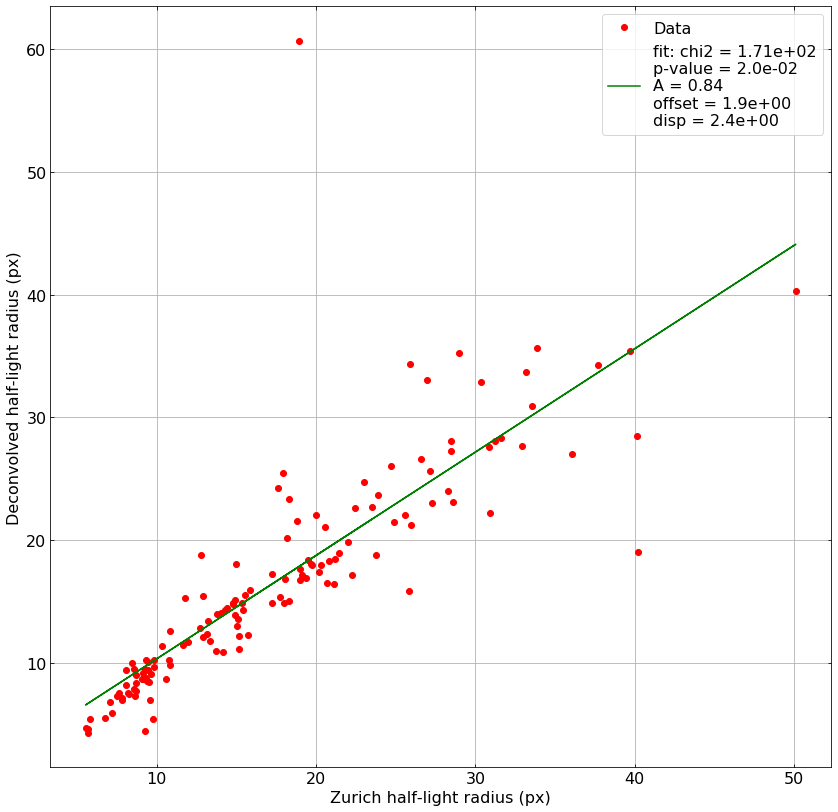

In [67]:
#Plotting Deconvolved radius from Zurich against Zurich radius
plt.rcParams["figure.figsize"] = (14, 14) # (w, h)

f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

#Transform Zurich radius from pixel to arcsec
# if R_half_Zurich2.unit == "pix":
#     R_half_Zurich2 *= 0.03
#     R_half_Zurich2.unit = "arcsec"

#Compute linear fit and perform chi-square test
(A, offset), pcov  = curve_fit(linear_fit, R_half_Zurich2, R_half_Deconv2, p0=[0.5, 1], check_finite=True)
sep_lin_fit        = linear_fit(R_half_Zurich2, A, offset)
chisq, pval        = chisquare(R_half_Deconv2, sep_lin_fit, ddof=2)

#Plot data
plt.plot(R_half_Zurich2, R_half_Deconv2, "ro", label="Data")

#Compute dispersion
disp = np.mean(np.abs(R_half_Deconv2-sep_lin_fit))

#Plot best fit
string = "fit: chi2 = %.2e\np-value = %.1e\nA = %.2f\noffset = %.1e\ndisp = %.1e" %(chisq, pval, A, offset, disp)
plt.plot(R_half_Zurich2, sep_lin_fit, "g", label=string)

plt.ylabel("Deconvolved half-light radius (px)", size=16)
plt.xlabel("Zurich half-light radius (px)", size=16)
plt.legend(loc='best', prop={'size': 16})

print("A = %.1f" %A, "\noffset = %.1e" %offset, "\ndisp = %.1e" %disp,
      "\np-value = %.2e" %pval)

# f.savefig("Plots/deconvolvedRadius_against_zurichRadius.pdf", bbox_inches='tight')

In [ ]:

### PLOTTING SECTION between Zurich/Cassata/Tasca data against GF###


In [13]:
#Remove incorrect values in GalFit radius column
GF_R           = table['R_d_GF']
mask           = np.logical_and(np.abs(GF_R)!=50, np.abs(GF_R)!=999)

GF_R           = GF_R[mask]
R_half_CASSATA = table['R_HALF_CASSATA'][mask]
R_half_TASCA   = table['R_HALF_TASCA'][mask]
R_half_Zurich  = table['R50_ZURICH'][mask]
R_half_Deconv  = table['R_0P5_GIM2D_ZURICH'][mask]
R_half_Conv    = table['R_GIM2D_ZURICH'][mask]
mass           = table['MASS_BEST'][mask]

print("There are values equal to +- 999 left in GF_R array, right ?", np.any(np.abs(GF_R)==999))

#Remove radii which were not given in Zurich catalog (nan values)
mask2           = np.logical_not(np.isnan(R_half_Zurich))
R_half_Zurich2  = R_half_Zurich[mask2]
GF_R2           = GF_R[mask2]
R_half_CASSATA2 = R_half_CASSATA[mask2]
R_half_TASCA2   = R_half_TASCA[mask2]
R_half_Deconv2  = R_half_Deconv[mask2]
R_half_Conv2    = R_half_Conv[mask2]
mass2           = mass[mask2]

print("There are values equal NaN left in R_half_Zurich2 array, right ?", np.any(np.isnan(R_half_Zurich2)))

m               = R_half_CASSATA2<50
R_half_CASSATA2 = R_half_CASSATA2[m]
R_half_TASCA2   = R_half_TASCA2[m]
R_half_Zurich2  = R_half_Zurich2[m]
R_half_Deconv2  = R_half_Deconv2[m]
R_half_Conv2    = R_half_Conv2[m]
GF_R2           = GF_R2[m]
mass2           = mass2[m]

#Remove raddi (deconvolved ones) which were nan
mask3           = np.logical_not(np.isnan(R_half_Deconv2))
R_half_Deconv2  = R_half_Deconv2[mask3]/0.03
R_half_Zurich2  = R_half_Zurich2[mask3]
GF_R2           = GF_R2[mask3]
R_half_CASSATA2 = R_half_CASSATA2[mask3]
R_half_TASCA2   = R_half_TASCA2[mask3]
R_half_Conv2    = R_half_Conv2[mask3]

print("There are values equal to NaN left in R_half_Deconv2 array, right ?", np.any(np.isnan(R_half_Deconv2)))

There are values equal to +- 999 left in GF_R array, right ? False
There are values equal NaN left in R_half_Zurich2 array, right ? False
There are values equal to NaN left in R_half_Deconv2 array, right ? False


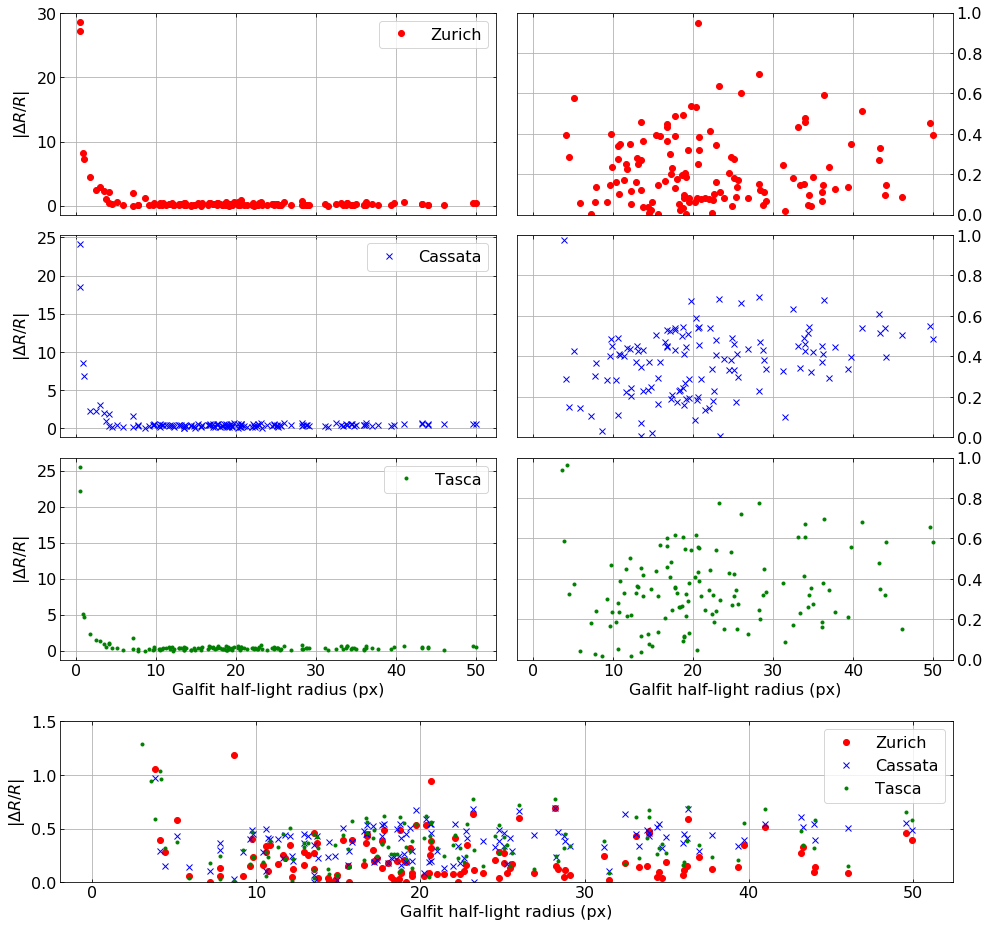

In [64]:
## Plotting the absolute difference in radii between Catalogs and GalFit radii against GalFit (in px)

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

#Plotting Zurich against GF radius
f   = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
ax1 = plt.subplot(421)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

#Plot data
tmp = np.abs(R_half_Zurich2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "ro", label="Zurich")

plt.ylabel(r"$\left | \Delta R /R \right |$", size=16)
plt.legend(loc='best', prop={'size': 16})

#Plotting Cassata radius against GF radius
ax2 = f.add_subplot(423)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

#Plot data
tmp = np.abs(R_half_CASSATA2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "bx", label="Cassata")

plt.ylabel(r"$\left |  \Delta R /R \right |$", size=16)
plt.legend(loc='best', prop={'size': 16})

#Plotting Tasca radius against GF radius
ax3 = f.add_subplot(425)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')
ax3.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

#Plot data
tmp = np.abs(R_half_TASCA2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "g.", label="Tasca")

plt.xlabel("Galfit half-light radius (px)", size=16)
plt.ylabel(r"$\left | \Delta R /R \right |$", size=16)
plt.legend(loc='best', prop={'size': 16})




#Second column (zoom in on relevant part)
#Plotting Zurich radius against GF radius
ax4 = plt.subplot(422)
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.tick_params(which='both', direction='in', labelsize=16)
ax4.yaxis.tick_right()
ax4.set_ylim(top=1)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

#Plot data
tmp = np.abs(R_half_Zurich2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "ro", label="Zurich")

#Plotting Cassata radius against GF radius
ax5 = f.add_subplot(424)
ax5.yaxis.set_ticks_position('both')
ax5.xaxis.set_ticks_position('both')
ax5.tick_params(which='both', direction='in', labelsize=16)
ax5.yaxis.tick_right()
ax5.set_ylim(top=1)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

#Plot data
tmp = np.abs(R_half_CASSATA2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "bx", label="Cassata")

#Plotting Tasca radius against GF radius
ax6 = f.add_subplot(426)
ax6.yaxis.set_ticks_position('both')
ax6.xaxis.set_ticks_position('both')
ax6.tick_params(which='both', direction='in', labelsize=16)
ax6.yaxis.tick_right()
ax6.set_ylim(top=1)
plt.grid()

#Plot data
tmp = np.abs(R_half_TASCA2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "g.", label="Tasca")
plt.xlabel("Galfit half-light radius (px)", size=16)



#Last subplot
ax7 = f.add_subplot(515)
ax7.yaxis.set_ticks_position('both')
ax7.xaxis.set_ticks_position('both')
ax7.tick_params(which='both', direction='in', labelsize=16)
ax7.set_ylim(top=1.5)
plt.grid()

#Plot data
tmp = np.abs(R_half_Zurich2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "ro", label="Zurich")
tmp = np.abs(R_half_CASSATA2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "bx", label="Cassata")
tmp = np.abs(R_half_TASCA2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "g.", label="Tasca")

plt.xlabel("Galfit half-light radius (px)", size=16)
plt.ylabel(r"$\left |  \Delta R /R \right |$", size=16)
plt.legend(loc='best', prop={'size': 16})

# f.savefig("Plots/relErr_against_GalFit1.5LightRadius_in_px.pdf", bbox_inches='tight')

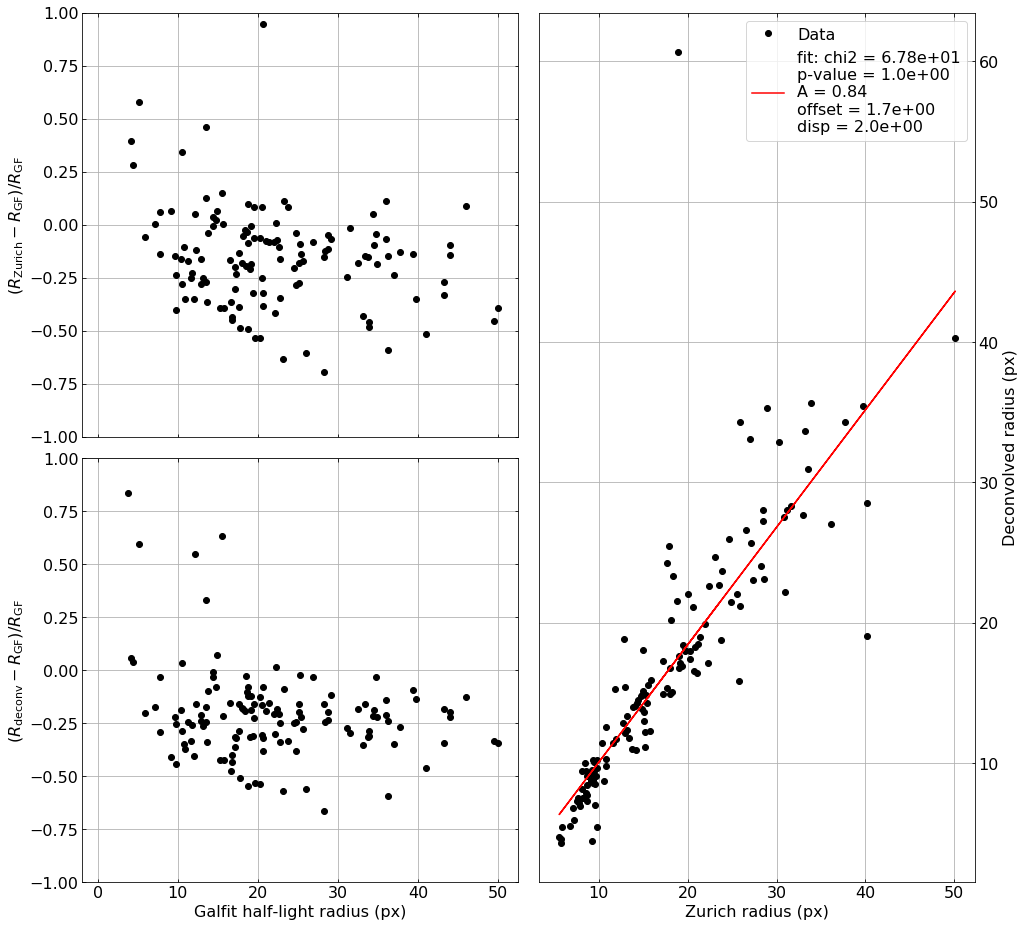

In [185]:
## Comparing plots between Zurich's and deconvolved radii

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

#Plotting Zurich against GF radius
f   = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax1 = plt.subplot(221)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=16)
ax1.axes.get_xaxis().set_ticklabels([])
ax1.set_ylim(top=1, bottom=-1)
plt.grid()

#Plot data
tmp = (R_half_Zurich2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "ko", label="Zurich")
plt.ylabel(r"$ (R_{\rm{Zurich}} - R_{\rm{GF}})/R_{\rm{GF}}$", size=16)


#Plotting Zurich radius against GF radius
ax4 = plt.subplot(223)
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.tick_params(which='both', direction='in', labelsize=16)
ax4.set_ylim(top=1, bottom=-1)
plt.grid()

#Plot data
tmp = (R_half_Deconv2 - GF_R2)/GF_R2
plt.plot(GF_R2, tmp, "ko", label="Zurich")
plt.xlabel("Galfit half-light radius (px)", size=16)
plt.ylabel(r"$ (R_{\rm{deconv}} - R_{\rm{GF}})/R_{\rm{GF}}$", size=16)


#Last subplot
ax7 = f.add_subplot(122)
ax7.yaxis.set_ticks_position('both')
ax7.xaxis.set_ticks_position('both')
ax7.tick_params(which='both', direction='in', labelsize=16)
ax7.yaxis.tick_right()
ax7.yaxis.set_label_position("right")
plt.grid()

#Removing the upper point for linear fitting
msk = R_half_Deconv2<60

#Compute linear fit and perform chi-square test
(A, offset), pcov  = curve_fit(linear_fit, R_half_Zurich2[msk], R_half_Deconv2[msk], p0=[0.5, 1], check_finite=True)
sep_lin_fit        = linear_fit(R_half_Zurich2[msk], A, offset)
chisq, pval        = chisquare(R_half_Deconv2[msk], sep_lin_fit, ddof=2)

#Plot data
plt.plot(R_half_Zurich2, R_half_Deconv2, "ko", label="Data")

#Compute dispersion
disp = np.mean(np.abs(R_half_Deconv2[msk]-sep_lin_fit))

#Plot best fit
string = "fit: chi2 = %.2e\np-value = %.1e\nA = %.2f\noffset = %.1e\ndisp = %.1e" %(chisq, pval, A, offset, disp)
plt.plot(R_half_Zurich2[msk], sep_lin_fit, "r", label=string)

plt.xlabel("Zurich radius (px)", size=16)
plt.ylabel("Deconvolved radius (px)", size=16)
plt.legend(loc='best', prop={'size': 16})

# f.savefig("Plots/zurichAndDeconvolvedRadii_against_Galfit.pdf", bbox_inches='tight')

In [ ]:

### Comparing catalogs morphological types ###


In [14]:
classCassata    = table['AUTOCLASS_CASSATA'][mask][mask2][m][mask3]
classTascaInt   = table['CLASS_INT_TASCA'][mask][mask2][m][mask3]
classTascaLinee = table['CLASS_LINEE_TASCA'][mask][mask2][m][mask3]
classTascaSVM   = table['CLASS_SVM_TASCA'][mask][mask2][m][mask3]
classZurich     = table['TYPE_ZURICH'][mask][mask2][m][mask3]

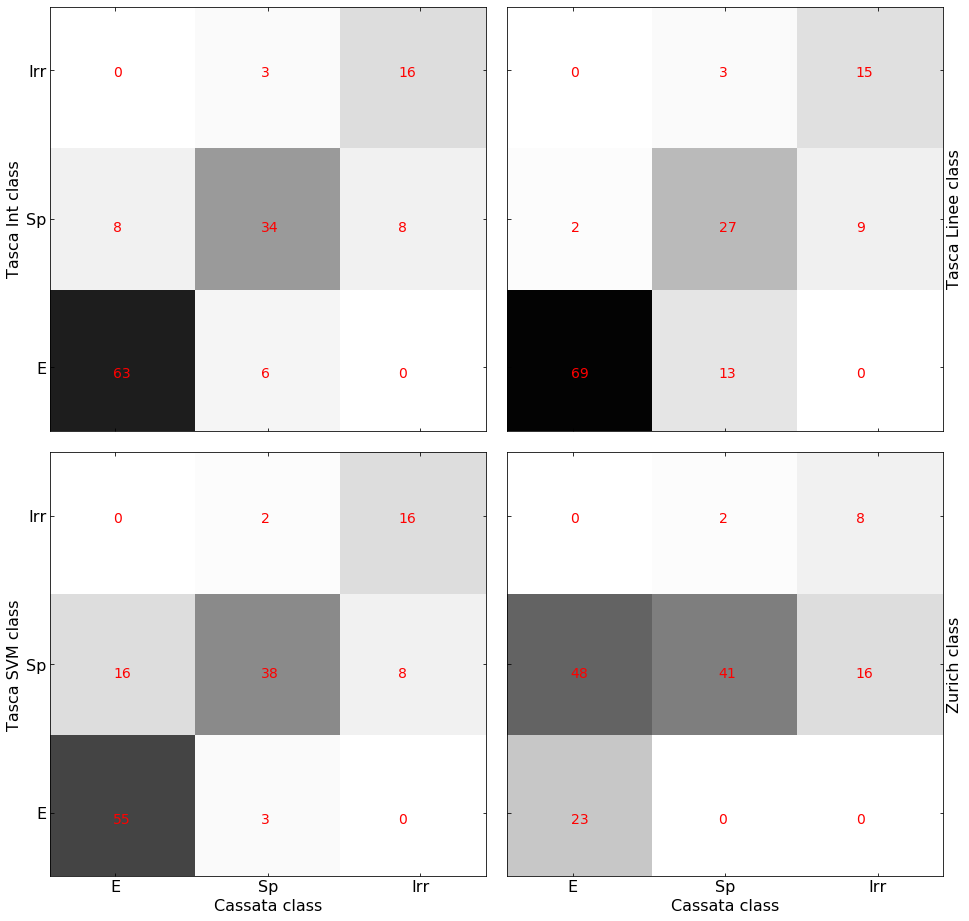

In [21]:
## Checking types are similar between catalogs

plt.rcParams["figure.figsize"] = (16, 16)

f = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

def onePlot(numPlot, datax, datay, hideXlabel=False, hideYlabel=False, vmax=None, vmin=None,
            hideColorbar=True, placeYaxisOnRight=False, 
            xlabel="Cassata class", ylabel='Tasca Int class'):
    
    ax1 = plt.subplot(numPlot)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(which='both', direction='in', labelsize=16)
    plt.xticks([1.3, 2, 2.7], ['E', 'Sp', 'Irr'])
    plt.yticks([1.3, 2, 2.7], ['E', 'Sp', 'Irr'])
    plt.grid()
    
    #hiding labels if required
    if hideXlabel:
        ax1.axes.get_xaxis().set_ticklabels([])
    else:
        plt.xlabel(xlabel, size=16)
        
    if hideYlabel:
        ax1.axes.get_yaxis().set_ticklabels([])
    plt.ylabel(ylabel, size=16)
    
    if placeYaxisOnRight:
        ax1.yaxis.set_label_position("right")

    #setting colorbar limits
    if vmax is None:
        vmax = 70
    if vmin is None:
        vmin = 0

    hist, xed, yed, im = plt.hist2d(datax, datay, bins=3, vmax=vmax, vmin=vmin, cmap='Greys')
    
    #hiding colorbar if required
    if not hideColorbar:
        plt.colorbar(im)

    for i, posi in enumerate([1.29, 1.97, 2.6]):
        for j, posj in enumerate([1.25, 1.94, 2.67]):
            plt.text(posi, posj, int(hist[i][j]), size=14, color='red')
    
    return im

im1 = onePlot(221, classCassata, classTascaInt, hideXlabel=True)
im1 = onePlot(222, classCassata, classTascaLinee, hideXlabel=True, hideYlabel=True,
              ylabel='Tasca Linee class', placeYaxisOnRight=True)
im1 = onePlot(223, classCassata, classTascaSVM, ylabel='Tasca SVM class')
im1 = onePlot(224, classCassata, classZurich, hideYlabel=True, ylabel='Zurich class',
             placeYaxisOnRight=True)

# f.savefig("Plots/comparisonClassTypes.pdf", bbox_inches='tight')

In [18]:

### Plotting as before but with colour coding on galaxy type ###


In [95]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)
#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])
#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50
#Keep values for which the morphological classes between catalogs are the same
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask)


#Apply master mask and retrieve data
R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH']], 
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

classCassata = classZurich

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


TYPE_ZURICH
-----------
        2.0
        2.0
        1.0
        2.0
        1.0
        2.0
        2.0
        2.0
        1.0
        2.0
        ...
        2.0
        2.0
        3.0
        3.0
        2.0
        2.0
        1.0
        1.0
        2.0
        3.0
        2.0
Length = 138 rows


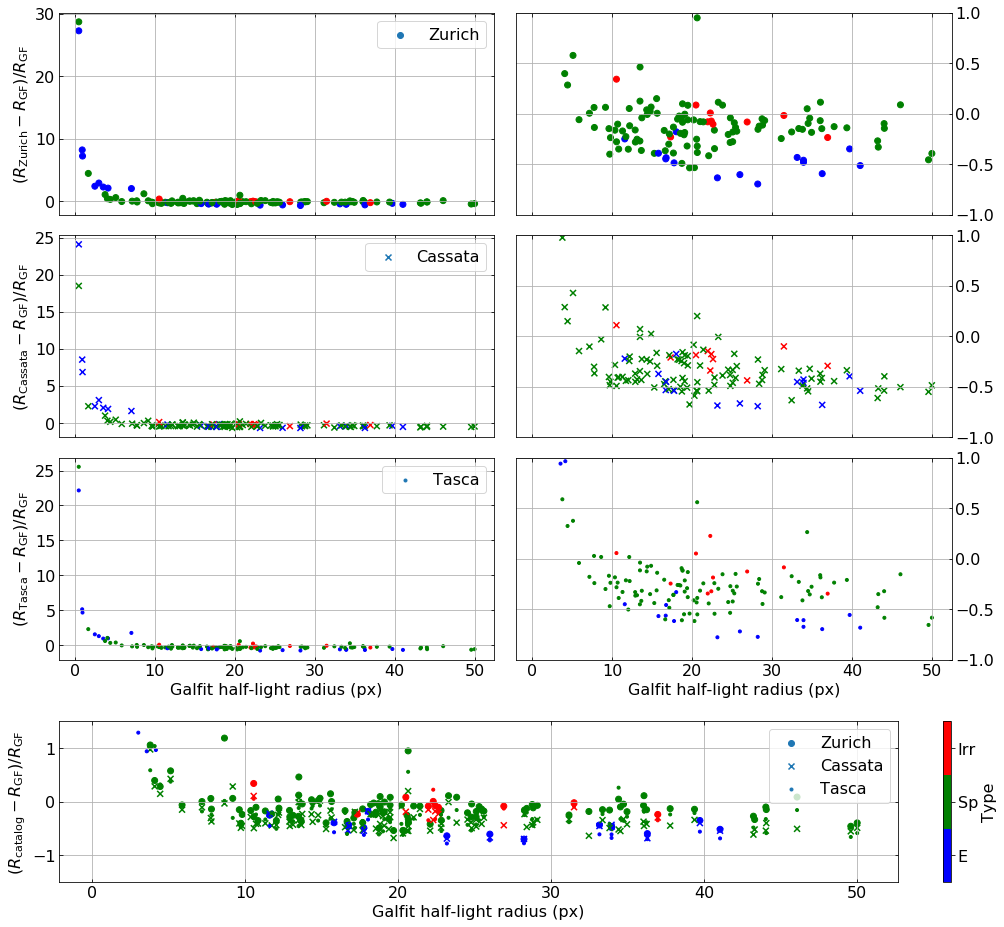

In [96]:
## Plotting the absolute difference in radii between Catalogs and GalFit radii against GalFit (in px)

from matplotlib.colors import from_levels_and_colors

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

def asManyPlots(numPlot, datax, datay, hideXlabel=False, hideYlabel=False, hideYticks=False,
                placeYaxisOnRight=False, xlabel="", ylabel='', marker='o', color='black', plotFlag=True,
                label='', zorder=0, textsize=16, showLegend=False, legendTextSize=16, linestyle='None',
                ylim=[None, None], xlim=[None, None], cmap=None, cmapMin=None, cmapMax=None):
    
    ax1 = plt.subplot(numPlot)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(which='both', direction='in', labelsize=16)
    plt.grid()
    
    #hiding labels if required
    if hideXlabel:
        ax1.axes.get_xaxis().set_ticklabels([])
    else:
        plt.xlabel(xlabel, size=textsize)    
    if hideYticks:
        ax1.axes.get_yaxis().set_ticklabels([])
    if not hideYlabel:    
        plt.ylabel(ylabel, size=textsize)
    
    #Place Y axis on the right if required
    if placeYaxisOnRight:
        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")
        
    #Define Y limits if required
    if ylim[0] is not None:
        ax1.set_ylim(bottom=ylim[0])
    if ylim[1] is not None:
        ax1.set_ylim(top=ylim[1])
    if xlim[0] is not None:
        ax1.set_xlim(left=xlim[0])
    if xlim[1] is not None:
        ax1.set_xlim(right=xlim[1])
    
    if plotFlag:
        plt.plot(datax, datay, label=label, marker=marker, color=color, zorder=zorder, linestyle=linestyle)
    else:
        if cmapMin is None:
            cmapMin = np.min(color)
        if cmapMax is None:
            cmapMax = np.max(color)
        
        tmp = plt.scatter(datax, datay, label=label, marker=marker, c=color, zorder=zorder, 
                          cmap=cmap, vmin=cmapMin, vmax=cmapMax)
#         plt.colorbar(tmp)
    if showLegend:
        plt.legend(loc='best', prop={'size': legendTextSize})
    
    return



f   = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

#Left plot for Zurich
asManyPlots(421, GF_R, (R_half_Zurich - GF_R)/GF_R, hideXlabel=True, label='Zurich',
            ylabel=r"$(R_{\rm{Zurich}} - R_{\rm{GF}} )/ R_{\rm{GF}}$", showLegend=True, marker="o",
            plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)

#Left plot for Cassata
asManyPlots(423, GF_R, (R_half_CASSATA - GF_R)/GF_R, hideXlabel=True, label='Cassata',
            ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}} )/ R_{\rm{GF}}$", showLegend=True, marker='x',
            plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)

#Left plot for Tasca
asManyPlots(425, GF_R, (R_half_TASCA - GF_R)/GF_R, label='Tasca', marker=".",
            ylabel=r"$(R_{\rm{Tasca}} - R_{\rm{GF}} )/ R_{\rm{GF}}$", 
            xlabel="Galfit half-light radius (px)", showLegend=True,
            plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)

#Right plot for Zurich
asManyPlots(422, GF_R, (R_half_Zurich - GF_R)/GF_R, hideXlabel=True, marker='o',
            ylabel=r"$(R_{\rm{Zurich}} - R_{\rm{GF}} )/ R_{\rm{GF}}$", hideYlabel=True,
            placeYaxisOnRight=True, ylim=[-1, 1],
            plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)

#Right plot for Cassata
asManyPlots(424, GF_R, (R_half_CASSATA - GF_R)/GF_R, hideXlabel=True, marker='x',
            ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}} )/ R_{\rm{GF}}$", hideYlabel=True,
            placeYaxisOnRight=True, ylim=[-1, 1],
            plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)

#Right plot for Tasca
asManyPlots(426, GF_R, (R_half_TASCA - GF_R)/GF_R, label='Tasca', marker='.', hideYlabel=True,
            xlabel="Galfit half-light radius (px)", placeYaxisOnRight=True, ylim=[-1, 1],
            plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)

#Last subplot
ax7 = f.add_subplot(515)
ax7.yaxis.set_ticks_position('both')
ax7.xaxis.set_ticks_position('both')
ax7.tick_params(which='both', direction='in', labelsize=16)
ax7.set_ylim(top=1.5, bottom=-1.5)
plt.grid()

#Plot data
plt.scatter(GF_R, (R_half_Zurich - GF_R)/GF_R, label="Zurich", c=classCassata,  marker='o',
            vmin=0.5, vmax=3.5, cmap=newcmap)
plt.scatter(GF_R, (R_half_CASSATA - GF_R)/GF_R, label="Cassata", c=classCassata, 
            marker='x', vmin=0.5, vmax=3.5, cmap=newcmap)
ret = plt.scatter(GF_R, (R_half_TASCA - GF_R)/GF_R, label="Tasca", c=classCassata, 
                  marker='.', vmin=0.5, vmax=3.5, cmap=newcmap)
col = plt.colorbar(ret, fraction=0.01)

col.set_ticks([1, 2, 3])
col.ax.set_yticklabels(['E', 'Sp', 'Irr'], size=16)
col.set_label("Type", size=16)

plt.xlabel("Galfit half-light radius (px)", size=16)
plt.ylabel(r"$  (R_{\rm{catalog}} - R_{\rm{GF}}) / R_{\rm{GF}}$", size=16)
plt.legend(loc='best', prop={'size': 16})

print(classCassata)

f.savefig("Plots/relErr_against_GalFit1.5LightRadius_colourCoded_zurichType.pdf", bbox_inches='tight')

In [ ]:

### Plotting Catalogs radii against mass ###


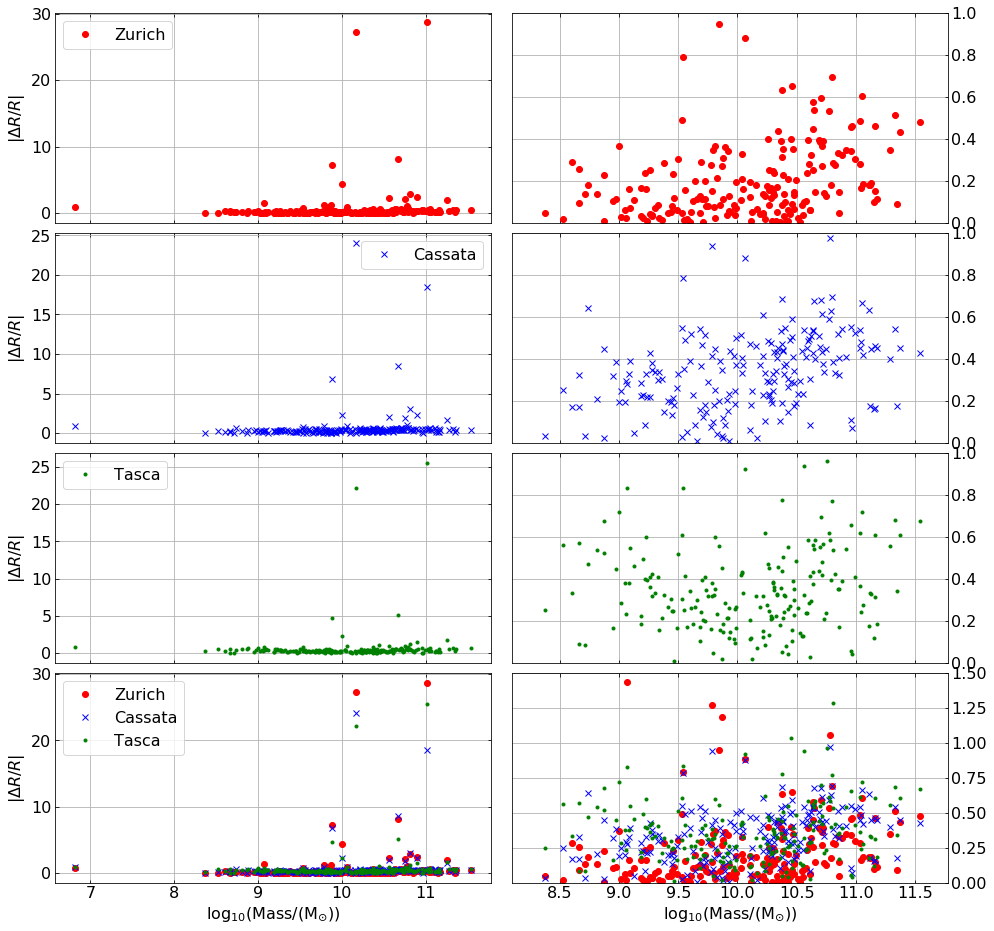

In [342]:
plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

#Removing point with a wrong mass
msk             = mass2>-20
mass3           = mass2[msk]
R_half_Zurich3  = R_half_Zurich2[msk]
R_half_CASSATA3 = R_half_CASSATA2[msk]
R_half_TASCA3   = R_half_TASCA2[msk]
GF_R3           = GF_R2[msk]

#Plotting Zurich against GF radius
f   = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax1 = plt.subplot(421)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

tmp                = np.abs(R_half_Zurich3 - GF_R3)/GF_R3

#Plot data
plt.plot(mass3, tmp, "ro", label="Zurich")

plt.ylabel(r"$\left | \Delta R  /R \right |$", size=16)
plt.legend(loc='best', prop={'size': 16})

#Plotting Cassata against GF radius
ax2 = f.add_subplot(423)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

tmp                = np.abs(R_half_CASSATA3 - GF_R3)/GF_R3

#Plot data
plt.plot(mass3, tmp, "bx", label="Cassata")

plt.ylabel(r"$\left | \Delta R /R \right |$", size=16)
plt.legend(loc='best', prop={'size': 16})

#Plotting Tasca against GF radius
ax3 = f.add_subplot(425)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')
ax3.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

tmp                = np.abs(R_half_TASCA3 - GF_R3)/GF_R3

#Plot data
plt.plot(mass3, tmp, "g.", label="Tasca")

plt.ylabel(r"$\left | \Delta R /R \right |$", size=16)
plt.legend(loc='best', prop={'size': 16})

#Plotting everything against GF radius
ax4 = plt.subplot(427)
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

#Plot data
tmp                = np.abs(R_half_Zurich3 - GF_R3)/GF_R3
plt.plot(mass3, tmp, "ro", label="Zurich")
tmp                = np.abs(R_half_CASSATA3 - GF_R3)/GF_R3
plt.plot(mass3, tmp, "bx", label="Cassata")
tmp                = np.abs(R_half_TASCA3 - GF_R3)/GF_R3
plt.plot(mass3, tmp, "g.", label="Tasca")

plt.xlabel(r'$\log_{10} (\rm{Mass}/(M_{\odot}))$', size=16)
plt.ylabel(r"$\left | \Delta R /R \right |$", size=16)
plt.legend(loc='best', prop={'size': 16})



#Plotting Zurich against GF radius
ax5 = f.add_subplot(422)
ax5.yaxis.set_ticks_position('both')
ax5.xaxis.set_ticks_position('both')
ax5.tick_params(which='both', direction='in', labelsize=16)
ax5.yaxis.tick_right()
ax5.set_xlim(left=8.1, right=max(ax4.get_xlim()))
ax5.set_ylim(top=1)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

tmp                = np.abs(R_half_Zurich3 - GF_R3)/GF_R3

#Plot data
plt.plot(mass3, tmp, "ro", label="Zurich")

#Plotting Cassata against GF radius
ax6 = f.add_subplot(424)
ax6.yaxis.set_ticks_position('both')
ax6.xaxis.set_ticks_position('both')
ax6.set_xlim(left=8.1, right=max(ax4.get_xlim()))
ax6.set_ylim(top=1)
ax6.tick_params(which='both', direction='in', labelsize=16)
ax6.yaxis.tick_right()
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

tmp                = np.abs(R_half_CASSATA3 - GF_R3)/GF_R3

#Plot data
plt.plot(mass3, tmp, "bx", label="Cassata")

#Plotting Tasca against GF radius
ax7 = f.add_subplot(426)
ax7.yaxis.set_ticks_position('both')
ax7.xaxis.set_ticks_position('both')
ax7.set_xlim(left=8.1, right=max(ax4.get_xlim()))
ax7.set_ylim(top=1)
ax7.tick_params(which='both', direction='in', labelsize=16)
ax7.yaxis.tick_right()
plt.grid()
tmp                = np.abs(R_half_TASCA3 - GF_R3)/GF_R3

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

#Plot data
plt.plot(mass3, tmp, "g.", label="Tasca")

#Plotting everything against GF radius
ax8 = f.add_subplot(428)
ax8.yaxis.set_ticks_position('both')
ax8.xaxis.set_ticks_position('both')
ax8.tick_params(which='both', direction='in', labelsize=16)
ax8.yaxis.tick_right()
ax8.set_xlim(left=8.1, right=max(ax4.get_xlim()))
ax8.set_ylim(top=1.5)
plt.grid()

#Plot data
tmp                = np.abs(R_half_Zurich3 - GF_R3)/GF_R3
plt.plot(mass3, tmp, "ro", label="Zurich")
tmp                = np.abs(R_half_CASSATA3 - GF_R3)/GF_R3
plt.plot(mass3, tmp, "bx", label="Cassata")
tmp                = np.abs(R_half_TASCA3 - GF_R3)/GF_R3
plt.plot(mass3, tmp, "g.", label="Tasca")

plt.xlabel(r'$\log_{10} (\rm{Mass}/(M_{\odot}))$', size=16)

f.savefig("Plots/relErr_against_mass.pdf", bbox_inches='tight')

In [ ]:

### PLOTTING SECTION between Zurich/Cassata/Tasca data against GF (| delta R /R | against mag)###


In [269]:
## Comparing different magnitudes

magGF      = table["Mag_d_GF"]
magTasca   = table['ACS_MAG_AUTO_TASCA']
magCassata = table['MAG_AUTO_ACS_CASSATA'] 
magZurich  = table['ACS_MAG_AUTO_ZURICH']

In [270]:
#Constructing and applying relevant masks
m = maskToRemoveVal([magGF, magTasca, magCassata, magZurich], val=-999, keep=False)

In [271]:
#Checking the masks did their job
magGF, magTasca, magCassata, magZurich = applyMask([magGF, magTasca, magCassata, magZurich], m)
findWhereIsValue([magGF, magTasca, magCassata, magZurich], -999)

No value -999 found within array number 0
No value -999 found within array number 1
No value -999 found within array number 2
No value -999 found within array number 3


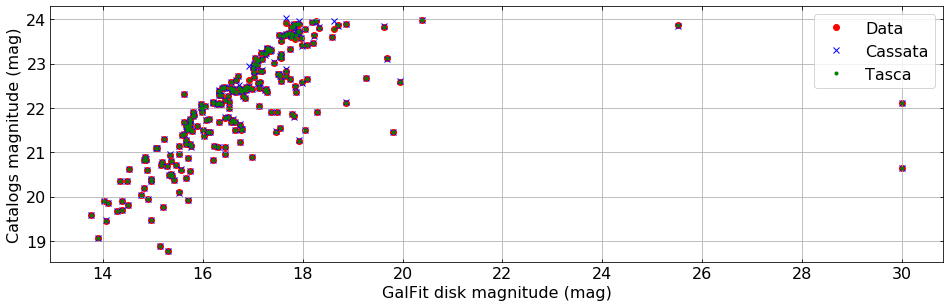

In [265]:
## Plotting Catalogs magnitudes against GalFit one

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

#Same as before but with the same scale
#Plotting Zurich against GF radius
f   = plt.figure()
ax4 = f.add_subplot(311)
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

#Plot data
plt.plot(magGF, magZurich, "ro", label="Data", zorder=1)
plt.plot(magGF, magCassata, "bx", label="Cassata", zorder=2)
plt.plot(magGF, magTasca, "g.", label="Tasca", zorder=3)

plt.xlabel("GalFit disk magnitude (mag)", size=16)
plt.ylabel("Catalogs magnitude (mag)", size=16)
plt.legend(loc='best', prop={'size': 16})

f.savefig("Plots/catalogMag_against_GalfitDiskMag.pdf", bbox_inches='tight')

In [272]:
#Remove incorrect values in GalFit radius column
GF_R           = table['R_d_GF']
mask           = np.logical_and(np.abs(GF_R)!=50, np.abs(GF_R)!=999)

GF_R           = GF_R[mask]
R_half_CASSATA = table['R_HALF_CASSATA'][mask]
R_half_TASCA   = table['R_HALF_TASCA'][mask]
R_half_Zurich  = table['R50_ZURICH'][mask]

magGF      = table["Mag_d_GF"][mask]
magCassata = table['MAG_AUTO_ACS_CASSATA'][mask]

print("There are values equal to +- 999 left in GF_R array, right ?", np.any(np.abs(GF_R)==999))

#Remove radii which were not given in Zurich catalog (nan values)
mask2           = np.logical_not(np.isnan(R_half_Zurich))
R_half_Zurich2  = R_half_Zurich[mask2]
R_half_CASSATA2 = R_half_CASSATA[mask2]
R_half_TASCA2   = R_half_TASCA[mask2]
GF_R2           = GF_R[mask2]

magGF           = magGF[mask2]
magCassata      = magCassata[mask2]

print("There are values equal to NaN left in R_half_Zurich2 array, right ?", np.any(np.isnan(R_half_Zurich2)))

m               = R_half_CASSATA2<50
R_half_CASSATA2 = R_half_CASSATA2[m]
R_half_TASCA2   = R_half_TASCA2[m]
R_half_Zurich2  = R_half_Zurich2[m]
GF_R2           = GF_R2[m]

magGF           = magGF[m]
magCassata      = magCassata[m]

#Constructing and applying relevant masks
m2 = maskToRemoveVal([magGF, magCassata], val=-999, keep=False)

#Checking the masks did their job
magGF, magCassata, R_half_CASSATA2, R_half_TASCA2, R_half_Zurich2, GF_R2 = applyMask([magGF, magCassata, R_half_CASSATA2, R_half_TASCA2, R_half_Zurich2, GF_R2], m2)
findWhereIsValue([magGF, magTasca, magCassata, magZurich], -999)

There are values equal to +- 999 left in GF_R array, right ? False
There are values equal to NaN left in R_half_Zurich2 array, right ? False
No value -999 found within array number 0
No value -999 found within array number 1
No value -999 found within array number 2
No value -999 found within array number 3


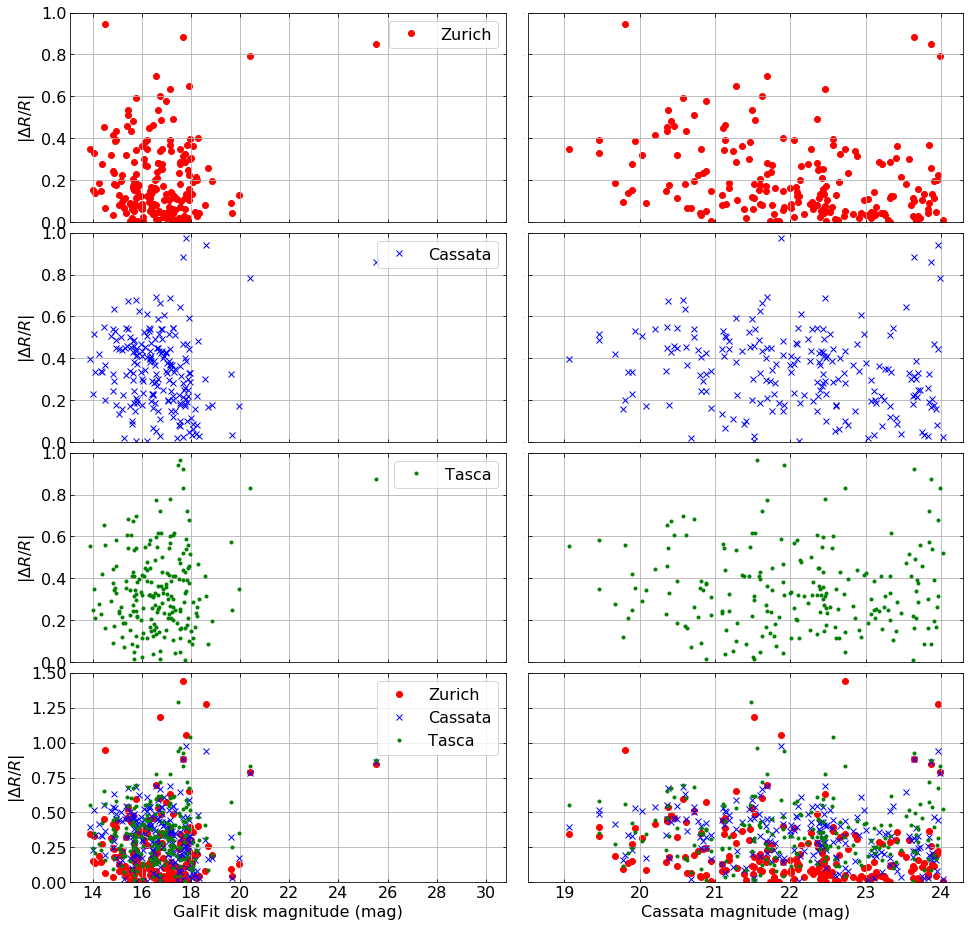

In [345]:
## Plotting absolute difference in radii between catalogs and GalFit against magnitude

plt.rcParams["figure.figsize"] = (16, 16)

tmp                = np.abs(R_half_Zurich2 - GF_R2)
tmp                = np.abs(R_half_CASSATA2 - GF_R2)
tmp                = np.abs(R_half_TASCA2 - GF_R2)

#Plotting Zurich against GF radius
f = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax4 = plt.subplot(421)
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.set_ylim(top=1)
ax4.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

#Plot data
tmp                = np.abs(R_half_Zurich2 - GF_R2)/GF_R2
plt.plot(magGF, tmp, "ro", label="Zurich", zorder=1)
plt.ylabel(r"$\left | \Delta R /R \right | $", size=16)
plt.legend(loc='best', prop={'size': 16})

#Plotting Cassata radius against GF radius
ax5 = f.add_subplot(423)
ax5.yaxis.set_ticks_position('both')
ax5.xaxis.set_ticks_position('both')
ax5.set_ylim(top=1)
ax5.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

#Plot data
tmp                = np.abs(R_half_CASSATA2 - GF_R2)/GF_R2
plt.plot(magGF, tmp, "bx", label="Cassata", zorder=2)
plt.ylabel(r"$\left | \Delta R /R \right | $", size=16)
plt.legend(loc='best', prop={'size': 16})

#Plotting Tasca radius against GF radius
ax6 = f.add_subplot(425)
ax6.yaxis.set_ticks_position('both')
ax6.xaxis.set_ticks_position('both')
ax6.set_ylim(top=1)
ax6.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

#Plot data
tmp                = np.abs(R_half_TASCA2 - GF_R2)/GF_R2
plt.plot(magGF, tmp, "g.", label="Tasca", zorder=3)
plt.legend(loc='best', prop={'size': 16})

plt.ylabel(r"$\left | \Delta R /R \right | $", size=16)




#Same as before but with Cassata magnitude
#Plotting Zurich against GF radius
ax10 = plt.subplot(422)
ax10.yaxis.set_ticks_position('both')
ax10.xaxis.set_ticks_position('both')
ax10.set_ylim(top=1)
ax10.tick_params(which='both', direction='in', labelsize=0)
plt.grid()

#Plot data
tmp                = np.abs(R_half_Zurich2 - GF_R2)/GF_R2
plt.plot(magCassata, tmp, "ro", label="Zurich", zorder=1)

#Plotting Cassata radius against GF radius
ax11 = f.add_subplot(424)
ax11.yaxis.set_ticks_position('both')
ax11.xaxis.set_ticks_position('both')
ax11.set_ylim(top=1)
ax11.tick_params(which='both', direction='in', labelsize=0)
plt.grid()

#Plot data
tmp                = np.abs(R_half_CASSATA2 - GF_R2)/GF_R2
plt.plot(magCassata, tmp, "bx", label="Cassata", zorder=2)

#Plotting Tasca radius against GF radius
ax12 = f.add_subplot(426)
ax12.yaxis.set_ticks_position('both')
ax12.xaxis.set_ticks_position('both')
ax12.set_ylim(top=1)
ax12.tick_params(which='both', direction='in', labelsize=0)
plt.grid()

#Plot data
tmp                = np.abs(R_half_TASCA2 - GF_R2)/GF_R2
plt.plot(magCassata, tmp, "g.", label="Tasca", zorder=3)



ax7 = plt.subplot(427)
ax7.yaxis.set_ticks_position('both')
ax7.xaxis.set_ticks_position('both')
ax7.set_ylim(top=1.5)
ax7.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

tmp                = np.abs(R_half_Zurich2 - GF_R2)/GF_R2
plt.plot(magGF, tmp, "ro", label="Zurich", zorder=1)
tmp                = np.abs(R_half_CASSATA2 - GF_R2)/GF_R2
plt.plot(magGF, tmp, "bx", label="Cassata", zorder=2)
tmp                = np.abs(R_half_TASCA2 - GF_R2)/GF_R2
plt.plot(magGF, tmp, "g.", label="Tasca", zorder=3)
plt.legend(loc='best', prop={'size': 16})

plt.xlabel("GalFit disk magnitude (mag)", size=16)
plt.ylabel(r"$\left | \Delta R /R \right |$", size=16)



ax8 = plt.subplot(4,2,8)
ax8.yaxis.set_ticks_position('both')
ax8.xaxis.set_ticks_position('both')
ax8.set_ylim(top=1.5)
ax8.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_ticklabels([])

tmp                = np.abs(R_half_Zurich2 - GF_R2)/GF_R2
plt.plot(magCassata, tmp, "ro", label="Zurich", zorder=1)
tmp                = np.abs(R_half_CASSATA2 - GF_R2)/GF_R2
plt.plot(magCassata, tmp, "bx", label="Cassata", zorder=2)
tmp                = np.abs(R_half_TASCA2 - GF_R2)/GF_R2
plt.plot(magCassata, tmp, "g.", label="Tasca", zorder=3)

plt.xlabel("Cassata magnitude (mag)", size=16)

# f.savefig("Plots/relErr_against_mag_zoomedIn.pdf", bbox_inches='tight')